# Basics of diffusion models
In the last few years diffusion models demonstrated to be a fundamental paradigm for generative modelling across a number of domains ranging from generating images, videos, proteins and much more. In this series of notebooks we're gonna take a look at them with a practical approach, implementing every step needed. Starting from the basics, we will see a first toy example, moving them to image generation and advanced approaches such as classifier-free guidance, flow matching and latent diffusion.
But first, let's start from the basics.

## What are diffusion models?
At a high level, diffusion models consist of two main processes:

- Forward Diffusion (The Destruction): We gradually add Gaussian noise to our data until it becomes unrecognizable random static. This is a fixed mathematical process (no neural network training yet).

- Reverse Diffusion (The Creation): We train a neural network to look at a slightly noisy image and predict the noise that was added. By subtracting this predicted noise step-by-step, we can go from pure static back to structured data.

So in the end, the generation process consists of our network learning to denoise a completely noisey starting sample towards a sample that resembles the distribution of data the model was trained on.
In this notebook we are going to see one of the basic formulation of diffusion models: DDPM (Denoising Diffusion Probabilistic Models).

In [81]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

### Step 1: The Data
Before we destroy data, we need data to destroy! For a toy example, 2D points (x, y coordinates) are easier to visualize than images. A "Swiss Roll" or a "Spiral" is a classic choice because it's hard for simple models to learn.

In [18]:
def plot_data(data, title=None):
    # plot initial data
    plt.figure(figsize=(6,6))
    plt.scatter(data[:, 0], data[:, 1], s=10, alpha=0.6, c='purple')
    plt.xlim(-1.2, 1.2)
    plt.ylim(-1.2, 1.2)
    if title:
        plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

def get_spiral_data(n_points=1000):
    theta = np.sqrt(np.random.rand(n_points)) * 720 * (np.pi / 180)
    r = 0.5 * theta 
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    data = np.stack([x, y], axis=1) + np.random.randn(n_points, 2) * 0.3
    data_max = np.max(np.abs(data))
    data = data / data_max
    return data.astype(np.float32)


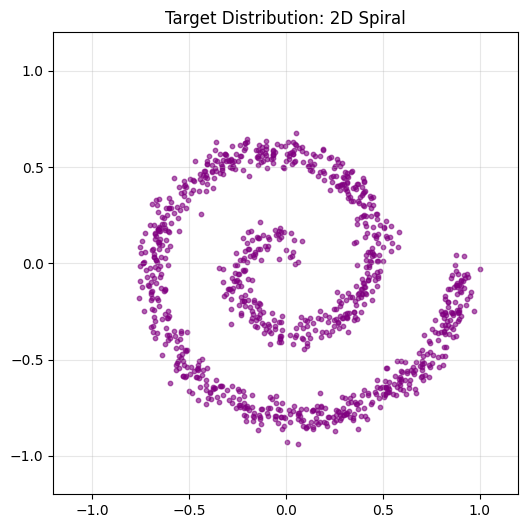

In [17]:
data = get_spiral_data()
plot_data(data, title="Target Distribution: 2D Spiral")

### Step 2: The Forward Diffusion Process
Our goal is to take this nice spiral (let's call it $x_0$) and slowly corrupt it over $T$ time steps until it looks like pure Gaussian noise ($x_T$). This step is called Forward Diffusion Process:
For each noising step, we add some amount of gaussian noise to the previous sample $x_{t-1}$ int the following way:
$$x_t = \sqrt{1 - \beta_t} \cdot x_{t-1} + \sqrt{\beta_t} \cdot \epsilon$$
Where:
- $\epsilon$: The Gaussian noise you mentioned.
- $\beta_t$ (beta): A small number between 0 and 1 that controls how much noise to add at this specific step.
Notice that our beta values have a dependence over time, as we define a scheduling over the steps where we slowly increase the values (a typical range is 1e-4 to 0.02).
<br>
The function below implements this forward diffusion process:

In [24]:
def forward_diffusion_step(x, t, betas):
    # sample gaussian noise
    noise = torch.randn_like(x)
    # get beta for current timestep
    b_t = betas[t]
    # add noise to x (forward diffusion)
    x_t = torch.sqrt(1-b_t) * x + torch.sqrt(b_t) * noise
    
    return x_t
    
def forward_diffusion(x, diffusion_steps, betas):
    x_values = [x]
    for i in range(diffusion_steps):
        x_t = forward_diffusion_step(x, i, betas)
        x_values.append(x_t)
        x = x_t
    return x, x_values

Let's now take a look at what's happening over time to our data!

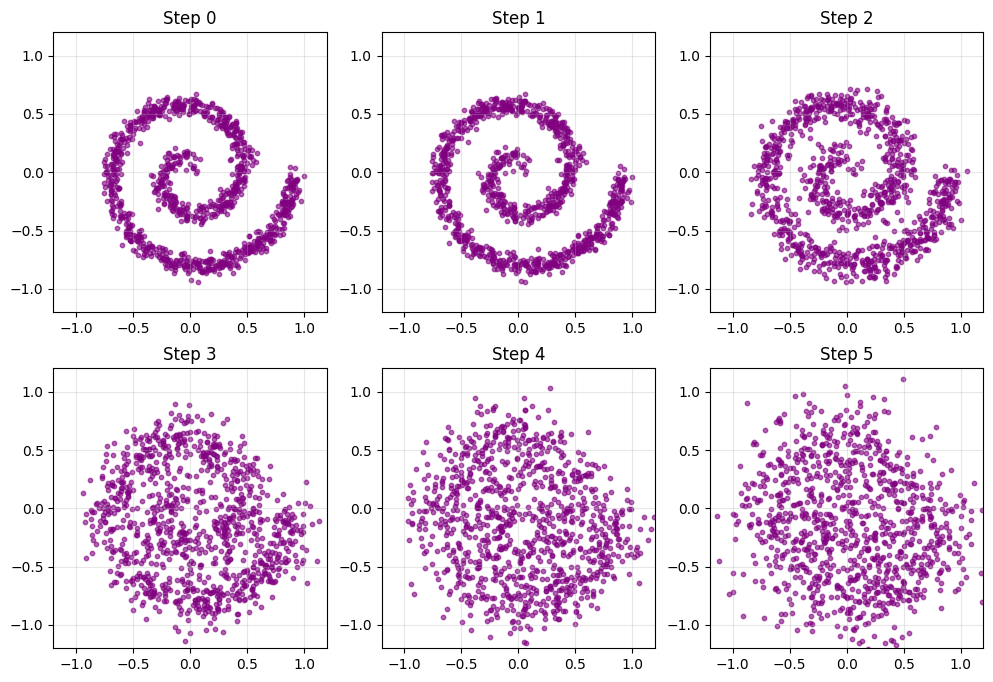

In [ ]:
diffusion_steps = 6
# schedule beta values
betas = torch.linspace(0.0001, 0.02, diffusion_steps)

x_0 = torch.tensor(data).float()
x_noisy, x_values = forward_diffusion(x_0, diffusion_steps, betas)

# plot progressive noising
fig, axs = plt.subplots(2, 3, figsize=(12,8))
for i in range(diffusion_steps):
    ax = axs[i//3, i%3]
    ax.scatter(x_values[i][:, 0].numpy(), x_values[i][:, 1].numpy(), s=10, alpha=0.6, c='purple')
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_title(f"Step {i}")
    ax.grid(True, alpha=0.3)

Actually, there's a much faster method to get a noisy sample at time $t$. Right now, we are required to loop through every forward diffusion step starting from the clean image. Turns out there is a mathematical shortcut to directly "teleport" to a certain noisy sample $x_t$ using just $x_0$. To do this, we usually define two helper variables:
- $\alpha_t = 1 - \beta_t$ (this represents how much "signal" we keep at each step).
- $\bar{\alpha}_t$ (read "alpha bar"): the cumulative product of all alphas up to time $t$.
The shortcut formula looks like this:
$$x_t = \sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \epsilon$$
Let's look at an implementation of it!

In [ ]:
def sample_t(x_0, t, alpha_bars):
    # sample noise
    epsilon = torch.randn_like(x_0)
    # get x_t using closed form equation
    x_t = torch.sqrt(alpha_bars[t]) * x_0 + torch.sqrt(1-alpha_bars[t]) * epsilon
    
    return x_t, epsilon

And here's the result:

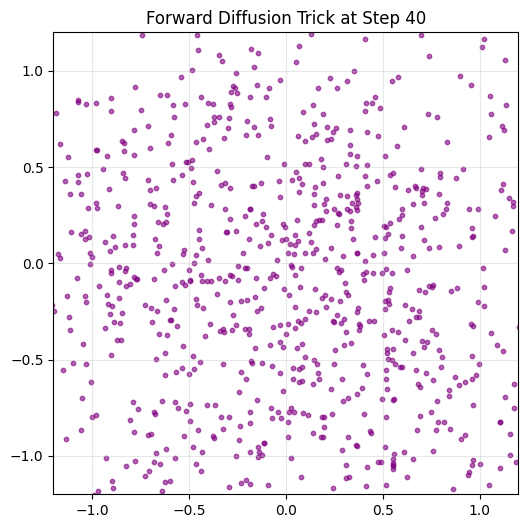

In [115]:
# Try playing with different time steps t
n_steps = 200
betas = torch.linspace(1e-4, 0.02, n_steps)
alphas = 1-betas
alpha_bars = torch.cumprod(alphas, dim=0)

t = 40
x_t, epsilon = sample_t(x_0, t, alpha_bars)

plot_data(x_t.numpy() - epsilon.numpy(), title=f"Forward Diffusion Trick at Step {t}")

### Step 3: The Backward Process
Now comes the interesting part: the reverse diffusion process. This is where our neural network comes into play. The goal is to learn how to "undo" the forward diffusion process, going from noisy data $x_t$ back to cleaner data $x_{t-1}$.

The key insight is that we train our network to predict the noise $\epsilon$ that was added during the forward process. Once we have this predicted noise, we can use it to reconstruct a cleaner version of the data. The reverse step formula looks like this:

$$x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \cdot \epsilon_\theta(x_t, t) \right) + \sigma_t \cdot z$$

Where:
- $\epsilon_\theta(x_t, t)$: The noise predicted by our neural network (parameterized by $\theta$).
- $\alpha_t = 1 - \beta_t$: How much signal we kept at step $t$.
- $\bar{\alpha}_t$: The cumulative product of alphas up to time $t$.
- $\sigma_t$: The variance of the noise we add back (for stochasticity).
- $z$: A random Gaussian noise sample (set to zero at the final step $t=0$).

The intuition here is that we're essentially "subtracting" the predicted noise from the noisy sample, then scaling and adding a small amount of randomness to get the previous timestep. By repeating this process from $x_T$ (pure noise) all the way down to $x_0$ (clean data), we can generate new samples that follow our training distribution.

The functions below implement this reverse diffusion process:


In [108]:
@torch.no_grad()
def sample(model, x_t, alpha_t, alpha_bar_t, sigma_t, t):
    epsilon = model(x_t, t)
    if t.numel() > 1:
        is_zero_timestep = (t[0] == 0)
    else:
        is_zero_timestep = (t.item() == 0)
        
    if is_zero_timestep:
        z = torch.zeros_like(x_t)
    else:
        z = torch.randn_like(x_t)
    x_prev = 1/torch.sqrt(alpha_t) * (x_t - (1-alpha_t)/torch.sqrt(1-alpha_bar_t) * epsilon) + sigma_t * z
    
    return x_prev

@torch.no_grad()
def reverse_diffusion(model, x_t, timesteps, device):  
    betas = torch.linspace(1e-4, 0.02, timesteps, device=device)
    alphas = 1-betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    
    batch_size = x_t.shape[0]  # Get the batch size
    
    model.eval()
    for t in range(timesteps-1, -1, -1):
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]
        sigma_t = torch.sqrt(betas[t])
        # Expand t to match batch size
        t_batch = torch.full((batch_size,), t, device=device, dtype=torch.long)
        x_prev = sample(model, x_t, alpha_t, alpha_bar_t, sigma_t, t_batch)
        x_t = x_prev
    return x_t
    

### Spiral generation
Now that we understand both the forward and backward processes, let's put it all together! We need to:

1. **Build a neural network** that can predict noise given a noisy sample and a timestep. This network needs to understand both the structure of the data (the spiral shape) and how much noise is present at different timesteps.

2. **Train the network** by showing it many examples of noisy spirals at different noise levels, and asking it to predict the noise that was added.

3. **Generate new spirals** by starting with pure noise and iteratively denoising it using our trained network.

The network architecture we'll use includes:
- **Time embeddings**: Since the amount of noise varies by timestep, we need to tell the network which timestep we're at. We use sinusoidal embeddings (similar to positional encodings in transformers) to encode the timestep.
- **Residual connections**: These help the network learn more effectively by allowing gradients to flow through multiple paths.
- **Layer normalization**: This stabilizes training and helps the network converge faster.

Let's start by defining the network components:


In [82]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
        
    def forward(self, t):
            device = t.device
            emb = torch.zeros(t.shape[0], self.embedding_dim, device=device)
            
            for i in range(self.embedding_dim // 2):
                # We ensure the constant is on the correct device too
                const = torch.tensor(10000.0, device=device) 
                omega_i = torch.exp(-(2*i/self.embedding_dim) * torch.log(const))
                
                emb[:, 2*i] = torch.sin(omega_i * t)
                emb[:, 2*i+1] = torch.cos(omega_i * t)
            
            return emb

In [83]:
class DenoiserNetwork(nn.Module):
    def __init__(self, sample_dim=2, time_embedding_dim=64, hidden_dim=256):
        super().__init__()
        
        self.time_embedder = SinusoidalEmbedding(time_embedding_dim)
        
        # Project time embedding to hidden dim
        self.time_mlp = nn.Sequential(
            nn.Linear(time_embedding_dim, hidden_dim),
            nn.SiLU(),  # SiLU (Swish) often works better than ReLU for diffusion
            nn.Linear(hidden_dim, hidden_dim),
        )
        
        # Input projection
        self.input_proj = nn.Linear(sample_dim, hidden_dim)
        
        # Main network with residual connections and normalization
        self.blocks = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(hidden_dim),
                nn.Linear(hidden_dim, hidden_dim),
                nn.SiLU(),
                nn.Linear(hidden_dim, hidden_dim),
            ) for _ in range(3)
        ])
        
        # Output projection
        self.output_proj = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, sample_dim),
        )
        
    def forward(self, x, t):
        # x: (batch_size, 2) noisy samples
        # t: (batch_size,) timesteps
        
        # Embed time
        t_emb = self.time_embedder(t)  # (batch, time_embedding_dim)
        t_emb = self.time_mlp(t_emb)   # (batch, hidden_dim)
        
        # Project input
        h = self.input_proj(x)  # (batch, hidden_dim)
        
        # Add time embedding (additive conditioning)
        h = h + t_emb
        
        # Residual blocks
        for block in self.blocks:
            h = h + block(h)  # Residual connection
        
        # Output
        return self.output_proj(h)

In [84]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

We make our spiral dataset such that within each batch we have a number of random noised samples, picked with the trick for forward diffusion we saw before.

In [ ]:
class SpiralDataset(Dataset):
    def __init__(self, n_points=1000, timesteps = 200):
        self.data = get_spiral_data(n_points)
        # plot initial data
        plot_data(self.data, title="Training Data: 2D Spiral")
        self.timesteps = timesteps
        self.alpha_bars = torch.cumprod(1-torch.linspace(1e-4, 0.02, timesteps), dim=0)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # sample a random timestep
        t = torch.randint(0, self.timesteps, (1,)).item()
        # get the data point
        x_0 = torch.tensor(self.data[index]).float()
        # get x_t and epsilon using the forward diffusion trick
        x_t, epsilon = sample_t(x_0, torch.tensor(t), self.alpha_bars)
        
        return x_t, t, epsilon
    

Using device: mps


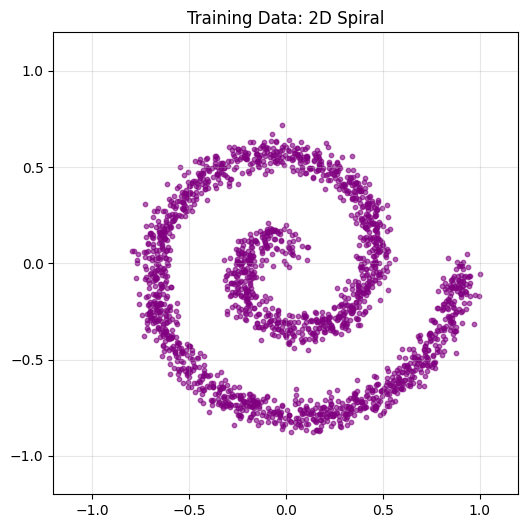

In [ ]:
timesteps = 300
n_points = 2000

# 1. Device Setup for M1
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# 2. Instantiate Dataset & DataLoader
dataset = SpiralDataset(n_points=n_points, timesteps=timesteps) # Make sure the fix is in here!
dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

# 3. Instantiate Model
model = DenoiserNetwork(sample_dim=2, time_embedding_dim=32, hidden_dim=256)
model.to(device)

# 4. Optimizer & Loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.MSELoss()

In [ ]:
num_epochs = 1000
model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for x_t, t, epsilon in dataloader:
        x_t = x_t.to(device)
        t = t.to(device)
        epsilon = epsilon.to(device)
        
        pred_epsilon = model(x_t, t)
        loss = loss_fn(pred_epsilon, epsilon)
        epoch_losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_loss = sum(epoch_losses) / len(epoch_losses)
    print(f"Epoch {epoch+1} loss: {avg_loss}")
    

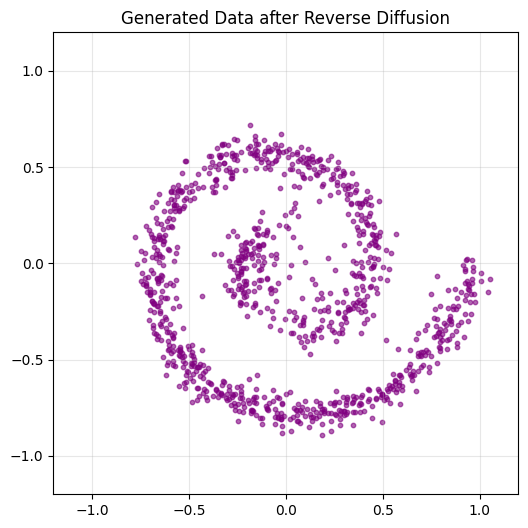

In [ ]:
# 1. Generate pure noise
x_T = torch.randn(n_points, 2).to(device)

# 2. Run the reverse process
# This might take a few seconds as it loops 300 times
generated_data = reverse_diffusion(model, x_T, timesteps, device=device)

# 3. Plot the result
generated_data = generated_data.cpu().numpy()

plot_data(generated_data, title="Generated Data after Reverse Diffusion")

### Conditional generation
So far, we've seen how to generate samples from a single distribution (the spiral). But what if we want to control what we generate? This is where conditional generation comes in.

The idea is simple: we add an additional input to our network that tells it what kind of sample we want to generate. In our case, we'll train on two different shapes: spirals and circles. The network will learn to generate spirals when given one label, and circles when given another.

To make this work, we need to:
1. **Modify the dataset** to include labels (0 for spiral, 1 for circle).
2. **Modify the network** to accept and process these labels. We'll use an embedding layer to convert the discrete label into a continuous vector that can be added to the network's hidden representations.
3. **Modify the sampling process** to pass the desired label during generation.

This same principle extends to more complex scenarios: you could condition on text descriptions (like "a red car"), class labels (like "cat" or "dog"), or any other metadata you have. The network learns to associate these conditions with different modes of the data distribution.

Let's start by creating a dataset with both shapes:

In [116]:
def get_circle_data(n_points=1000):
    theta = np.random.rand(n_points) * 2 * np.pi
    r = 0.8 # Fixed radius
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    
    # Stack and add noise
    data = np.stack([x, y], axis=1) + np.random.randn(n_points, 2) * 0.06
    return data

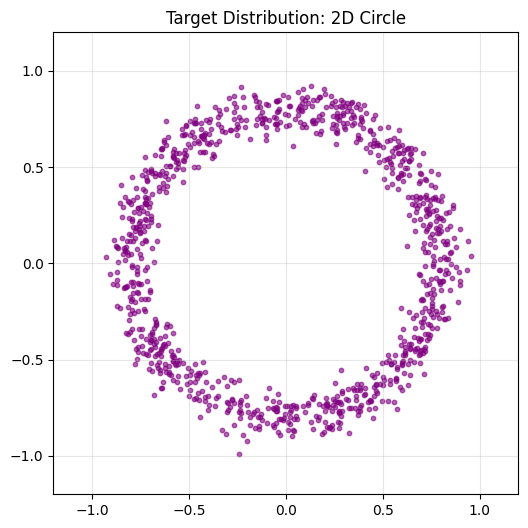

In [117]:
circle_data = get_circle_data()
plot_data(circle_data, title="Target Distribution: 2D Circle")

In [118]:
class DualShapeDataset(Dataset):
    def __init__(self, n_points=1000, timesteps = 200):
        self.spiral_data = torch.tensor(get_spiral_data(n_points)).float()
        self.circle_data = torch.tensor(get_circle_data(n_points)).float()

        self.data = torch.cat([self.spiral_data, self.circle_data], dim=0)
        self.labels = torch.cat([torch.zeros(n_points).long(), torch.ones(n_points).long()])
        
        self.timesteps = timesteps
        self.alpha_bars = torch.cumprod(1-torch.linspace(1e-4, 0.02, timesteps), dim=0)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        t = torch.randint(0, self.timesteps, (1,)).item()
        x_0 = torch.tensor(self.data[index]).float()
        x_t, epsilon = sample_t(x_0, torch.tensor(t), self.alpha_bars)
        label = self.labels[index]
        
        return x_t, t, epsilon, label
    

Our conditional version of the diffusion model shares all core components with the unconditional one, but implements a new linear layer that embeds the label (0 or 1 in this case) and after projection adds it to the time embedding to condition the generation.

In [119]:
class ConditionalDenoiserNetwork(nn.Module):
    def __init__(self, sample_dim=2, time_embedding_dim=64, hidden_dim=256, num_classes=2):
        super().__init__()
        
        self.time_embedder = SinusoidalEmbedding(time_embedding_dim)
        
        # Project time embedding to hidden dim
        self.time_mlp = nn.Sequential(
            nn.Linear(time_embedding_dim, hidden_dim),
            nn.SiLU(),  # SiLU (Swish) often works better than ReLU for diffusion
            nn.Linear(hidden_dim, hidden_dim),
        )
        
        # Input projection
        self.input_proj = nn.Linear(sample_dim, hidden_dim)
        
        # Label embedding
        self.label_embedder = nn.Embedding(num_classes, hidden_dim)
        
        # Main network with residual connections and normalization
        self.blocks = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(hidden_dim),
                nn.Linear(hidden_dim, hidden_dim),
                nn.SiLU(),
                nn.Linear(hidden_dim, hidden_dim),
            ) for _ in range(3)
        ])
        
        # Output projection
        self.output_proj = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, sample_dim),
        )
        
    def forward(self, x, t, label):
        # x: (batch_size, 2) noisy samples
        # t: (batch_size,) timesteps
        
        # Embed time
        t_emb = self.time_embedder(t)  # (batch, time_embedding_dim)
        t_emb = self.time_mlp(t_emb)   # (batch, hidden_dim)
        
        # Project input
        h = self.input_proj(x)  # (batch, hidden_dim)
        
        # Add time embedding (additive conditioning)
        h = h + t_emb
        
        # Add label embedding (additive conditioning)
        label_emb = self.label_embedder(label)
        h = h + label_emb
        
        # Residual blocks
        for block in self.blocks:
            h = h + block(h)  # Residual connection
        
        # Output
        return self.output_proj(h)

In [120]:
timesteps = 300
n_samples = 2000
# 1. Device Setup for M1
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# 2. Instantiate Dataset & DataLoader
dataset = DualShapeDataset(n_points=2000, timesteps=timesteps) # Make sure the fix is in here!
dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

# 3. Instantiate Model
model = ConditionalDenoiserNetwork(sample_dim=2, time_embedding_dim=32, hidden_dim=256, num_classes=2)
model.to(device)

# 4. Optimizer & Loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.MSELoss()

Using device: mps


In [ ]:
num_epochs = 1000
model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for x_t, t, epsilon, labels in dataloader:
        x_t = x_t.to(device)
        t = t.to(device)
        epsilon = epsilon.to(device)
        labels = labels.to(device)
        pred_epsilon = model(x_t, t, labels)
        loss = loss_fn(pred_epsilon, epsilon)
        epoch_losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_loss = sum(epoch_losses) / len(epoch_losses)
    print(f"Epoch {epoch+1} loss: {avg_loss}")

In [122]:
@torch.no_grad()
def sample_conditional(model, label,x_t, alpha_t, alpha_bar_t, sigma_t, t):
    epsilon = model(x_t, t, label)
    if t.numel() > 1:
        is_zero_timestep = (t[0] == 0)
    else:
        is_zero_timestep = (t.item() == 0)
        
    if is_zero_timestep:
        z = torch.zeros_like(x_t)
    else:
        z = torch.randn_like(x_t)
    x_prev = 1/torch.sqrt(alpha_t) * (x_t - (1-alpha_t)/torch.sqrt(1-alpha_bar_t) * epsilon) + sigma_t * z
    
    return x_prev

@torch.no_grad()
def reverse_diffusion_conditional(model, x_t, label,timesteps, device):  
    betas = torch.linspace(1e-4, 0.02, timesteps, device=device)
    alphas = 1-betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    
    batch_size = x_t.shape[0]  # Get the batch size
    
    model.eval()
    for t in range(timesteps-1, -1, -1):
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]
        sigma_t = torch.sqrt(betas[t])
        # Expand t to match batch size
        t_batch = torch.full((batch_size,), t, device=device, dtype=torch.long)
        x_prev = sample_conditional(model, label, x_t, alpha_t, alpha_bar_t, sigma_t, t_batch)
        x_t = x_prev
    return x_t
    

In [123]:
def predict_and_plot_conditional(model, label, timesteps):
    # 1. Generate pure noise
    label = torch.tensor([label]).to(device)
    x_T = torch.randn(n_samples, 2).to(device)

    # 2. Run the reverse process
    # This might take a few seconds as it loops 300 times
    generated_data = reverse_diffusion_conditional(model, x_T, label, timesteps, device=device)

    # 3. Plot the result
    generated_data = generated_data.cpu().numpy()
    plot_data(generated_data, title=f"Generated Data after Reverse Diffusion (Label={label.item()})")


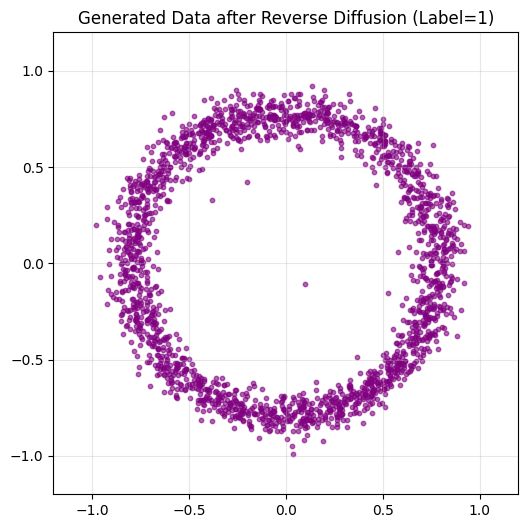

In [126]:
# Generate and plot data conditioned on label
label = 1  # 0: Spiral, 1: Circle
predict_and_plot_conditional(model, label, timesteps)

## Final Thoughts

Great! We've now implemented a complete diffusion model from scratch. Let's recap what we covered:

**Key Concepts:**
- **Forward Diffusion**: A fixed process that gradually adds noise to data, transforming clean samples into pure Gaussian noise.
- **Reverse Diffusion**: A learned process where a neural network predicts and removes noise, allowing us to generate new samples from pure noise.
- **Conditional Generation**: Extending the model to generate specific types of samples by conditioning on labels or other metadata.

**What Makes This Powerful:**
The beauty of diffusion models lies in their simplicity and effectiveness. By breaking down generation into many small denoising steps, the model can learn complex data distributions without needing adversarial training (like GANs) or complex likelihood computations (like VAEs). Each step is relatively simple (just predict noise) but the cumulative effect is the ability to generate high-quality, diverse samples.

**Next Steps:**
This notebook covered the fundamentals, but there's so much more to explore:
- **Classifier-Free Guidance**: A technique to improve conditional generation quality by training with both conditional and unconditional objectives.
- **Flow Matching**: An alternative formulation that can be faster and more stable than traditional diffusion.
- **Latent Diffusion**: Working in a compressed latent space (like Stable Diffusion) to generate high-resolution images efficiently.
- **Gradient-Based Optimization**: Optimize the generation at test-time guided by a function that steers the generation towards a specific objective.

The foundation we've built here will help you understand these more advanced techniques.
